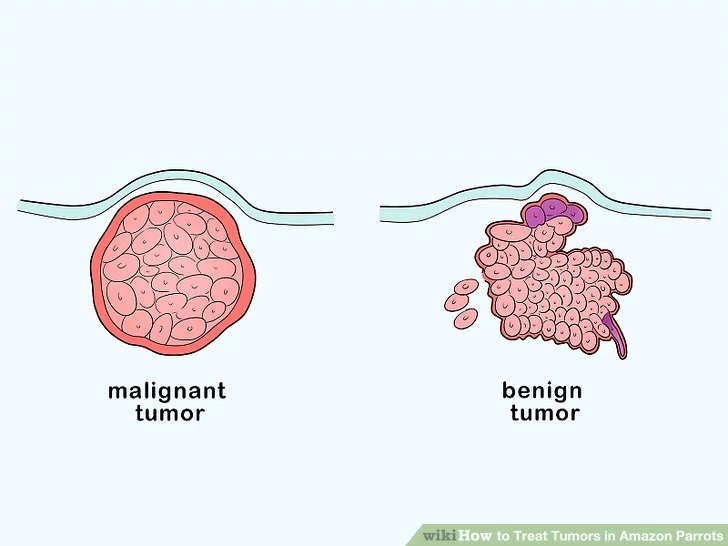

Hello Kagglers!!
- This is my first simple kernel. Hope you will go through it and give your feedback. 

**2. About Data**
Attribute Information:
* id
* diagnosis: M = malignant, B = benign
* Columns 3 to 32

Ten real-valued features are computed for each cell nucleus:

* radius: distances from center to points on the perimeter
* texture: standard deviation of gray-scale values
* perimeter
* area
* smoothness: local variation in radius lengths
* compactness: perimeter^2 / area - 1.0
* concavity: severity of concave portions of the contour
* concave points: number of concave portions of the contour
* symmetry
* fractal dimension: "coastline approximation" - 1
The mean, standard error, and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

In [ ]:
#Import necessory libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix,classification_report,precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import plotly 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# Get the CSV data here and print head
df = pd.read_csv("/kaggle/input/breast-cancer/breast cancer.csv",index_col=0)
df.head()

In [ ]:
#print summary
print ('Shape        ------>', df.shape)
print ('Each Column and data type and its count','\n')
print ( df.info())

In [ ]:
#DROP ALERT 1 : Unnamed:32 column has all nulls. Safe to remove the column.
df = df.drop(['Unnamed: 32'],axis=1)

In [ ]:
# Dataframe statistics
df.describe()

Seems no other columns have nulls. It's safe to proceed.

In [ ]:
# Validate each class to understand if the dataset is imbalanced.

print ('Total Belign Tumor (B)    :  {} and its percentage is {} %'.format(df.diagnosis.value_counts()[0], round(df.diagnosis.value_counts()[0]/df.diagnosis.value_counts().sum()*100,2)) )
print ('Total Malignant Tumor (M) :  {} and its percentage is {} %'.format(df.diagnosis.value_counts()[1], round(df.diagnosis.value_counts()[1]/df.diagnosis.value_counts().sum()*100,2)) )


Dataset is not imbalanced, we are good to go.

In [ ]:
#Plot each class freequency
plt.figure(figsize=(6,4))
sns.countplot(x='diagnosis',data=df,palette='rocket')

**Diagnosis is a label column and has 2 classes 'M' (Malignant) and 'B' (Belign) tumor.**
1. As there are many features, let's try to see if we can reduce the features using different techniques.
2. Let's plot heatmap to visualize and find the coefficient of multicollinearity.

In [ ]:
df_corr = df.corr().abs()
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 20))
sns.heatmap(df_corr, mask=mask, vmin=-1, vmax=1, annot=True,
            square=True, center=0, linewidths=.5)
plt.tight_layout()

In [ ]:
#Shape of df_corr (just to cross verify)
print ('Correlation matrix Shape =  ', df_corr.shape)

As we can see each feature data scaled differently. Let's go ahead and scale the data

In [ ]:
scaler = StandardScaler()
X = df.drop('diagnosis', axis=1)
X_scaled = scaler.fit_transform(X)

Using heatmap we got to know there are many features have colinearity. We are going to use PCA to pick top components which can explain maximum variance and later we use same components for training and testing. 

In [ ]:
pca = PCA()
pca.fit_transform(X_scaled)

Let's figure out the right number of components by plotting explained_variance_ratio_

In [ ]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal Components')
plt.ylabel('Variance Covered')
plt.title('PCA')
plt.show()

Around 13 Principal Components are able to explain > 95 % variance. It's safe to pick starting 13 PC's.
* Let's create those 13 components for further analysis.

In [ ]:
pca = PCA(n_components=13)
new_pcomp = pca.fit_transform(X_scaled)
princi_comp = pd.DataFrame(new_pcomp,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC7','PC9','PC10','PC11','PC12','PC13'])
princi_comp

Replace Label column (diagnosis) into binary codes.

In [ ]:

df['diagnosis'] = df['diagnosis'].replace({'M':1,'B':0})

Seperating labelled data

In [ ]:
y = df['diagnosis']

Model Buidling and prediction

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(princi_comp,y,test_size = 0.25, random_state= 355)

clf = LogisticRegression()
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)

Generate Classification report to find Precision,Recall and F1 score.

In [ ]:
print (classification_report(y_test,y_pred,digits=2))

Plot Precision vs Recall curve

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.step(recall, precision, color='r', alpha=0.8,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

Finally generating confusion matrix

In [ ]:
cfm = confusion_matrix(y_test,y_pred)
cfm

In [ ]:
tp = cfm[0,0]
fp = cfm[0,1]
fn = cfm[1,0]
tn = cfm[1,1]
print ('True Positive  >', tp)
print ('False Positive >', fp)
print ('False Negetive >', fn)
print ('True Negetive  >', tn)

Plot heatmap for confusion matrix 

In [ ]:
ax=plt.subplot()
sns.heatmap(cfm,annot=True,ax=ax,linewidths=5,linecolor='b',center=0)
ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')
ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['Belign','Malignant'])
ax.yaxis.set_ticklabels(['Belign','Malignant'])
plt.show()

In [ ]:
print ('Final prediction >', round((tp+tn)/(len(y_pred))*100,2))

Our model is able to predict with 97.9% accuracy of the test data. You can use many other techniques to find the best hyperparams to improve the accuracy.

Thank you so much for going through this report. I have been thinking to start my journey in kaggle from last few months, finally I am here.This is my first ever Kernel on Kaggle. Hoping you find it useful. If, please leave your comments and give thumbs up. Happy learning Kagglers. You people are awesome.:)